# Examining socio-demographic factors that influence in European voters

## Leave or remain in the European Union? 

<img src='https://static.dezeen.com/uploads/2021/02/brexit-designers-cost-admin_dezeen_2364_col_1-2048x1152.jpg' style='height:400px'>

<div class="list-group" id="list-tab" role="tablist">
  <h1 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">&nbsp;Table of Contents:</h1>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#1" role="tab" aria-controls="profile">1. Introduction<span class="badge badge-primary badge-pill">1</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#2" role="tab" aria-controls="messages">2. Data Cleaning & Wrangling<span class="badge badge-primary badge-pill">2</span></a>
   <a class="list-group-item list-group-item-action" data-toggle="list" href="#3" role="tab" aria-controls="messages">3. Survey Weight<span class="badge badge-primary badge-pill">3</span></a>
   <a class="list-group-item list-group-item-action" data-toggle="list" href="#4" role="tab" aria-controls="messages">4. Data Exploration<span class="badge badge-primary badge-pill">4</span></a>    <a class="list-group-item list-group-item-action" data-toggle="list" href="#5" role="tab" aria-controls="messages">5. Previous Iterations<span class="badge badge-primary badge-pill">5</span></a>
</div>

<a id="1"></a> <br>
<font size="+3" color="black"><b>1 - Introduction</b></font><br><a id="1"></a>
<br> 

This report will investigated a dataset provided by [European Social Survey](https://www.europeansocialsurvey.org/) (ESS) which is a biennial cross-national survey of attitudes and behaviour from European citizens.

The study will focus on which aspects can influence for a person to vote for your country leave or remain a member of the European Union. After analyzing each variable individually I will build a model that after been trained can predict the probability on a person to vote for your country to Leave the European Union.



## Data Dictionary

- __CNTRY__ Country
- __EDUYRS__ Years of full-time education completed
- __UEMP3M__ Ever unemployed and seeking work for a period more than three months
- __MBTRU__ Member of trade union or similar organisation
- __VTEURMMB__ Would vote for your country to remain member of European Union or leave

EDUYRS Years of full-time education completed
Question:
All rounds: About how many years of education have you completed, whether full-time or part-time? Please report these in full-time equivalents and include compulsory years of schooling.
Values and categories:
77	Refusal
88	Don't know
99	No answer

UEMP3M Ever unemployed and seeking work for a period more than three months
Question:
All rounds: Have you ever been unemployed and seeking work for a period of more than three months?
Values and categories:
1	Yes
2	No
7	Refusal
8	Don't know
9	No answer

MBTRU Member of trade union or similar organisation
Question:
ESS1, ESS2, ESS3, ESS4, ESS5, ESS6, ESS7, ESS8: Are you or have you ever been a member of a trade union or similar organisation?
ESS9: Are you or have you ever been a member of a trade union or similar organisation? IF YES, is that currently or previously?
Values and categories:
1	Yes, currently
2	Yes, previously
3	No
7	Refusal
8	Don't know
9	No answer

VTEURMMB Would vote for [country] to remain member of European Union or leave
Question:
ESS8, ESS9: Imagine there were a referendum in [country] tomorrow about membership of the European Union. Would you vote for [country] to remain a member of the European Union or to leave the European Union?
Values and categories:
1	Remain member of the European Union
2	Leave the European Union
33	Would submit a blank ballot paper
44	Would spoil the ballot paper
55	Would not vote
65	Not eligible to vote
77	Refusal
88	Don't know
99	No answer

### Notebook settings

In [1]:
# Change the default plots size 
options(repr.plot.width=15, repr.plot.height=10)
options(warn=-1)

### Libraries

In [45]:
library(essurvey)
library(dplyr)
library(ggplot2)
library(ggthemes)
library(gghighlight)
library(foreign)
library(survey)
library(srvyr)

## Data Extraction

__Selecting the variables which will be used for the data analysis__

In [3]:
survey_rawdata <- read.spss("ESS9e03_1.sav", use.value.labels=T, max.value.labels=Inf, to.data.frame=TRUE)

In [4]:
head(survey_rawdata)

,name,essround,edition,proddate,idno,cntry,nwspol,netusoft,netustm,ppltrst,⋯,inwemm,inwtm,dweight,pspwght,pweight,anweight,domain,prob,stratum,psu
,<chr>,<dbl>,<chr>,<chr>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ESS9e03_1,9,3.1,17.02.2021,27,Austria,60,Every day,180,2,⋯,7,46,0.5811743,0.2181114,0.3020914,0.06588958,2,0.0011755485,59,1688
2,ESS9e03_1,9,3.1,17.02.2021,137,Austria,10,Every day,20,7,⋯,6,73,1.0627724,0.4134733,0.3020914,0.12490674,2,0.0006428456,79,88
3,ESS9e03_1,9,3.1,17.02.2021,194,Austria,60,Most days,180,5,⋯,48,92,1.3765086,2.2702928,0.3020914,0.68583600,2,0.0004963272,11,938
4,ESS9e03_1,9,3.1,17.02.2021,208,Austria,45,Every day,120,3,⋯,49,134,0.9933993,0.3864834,0.3020914,0.11675334,2,0.0006877382,74,1998
5,ESS9e03_1,9,3.1,17.02.2021,220,Austria,30,Never,NA,5,⋯,39,40,0.3773534,1.0321022,0.3020914,0.31178924,2,0.0018105009,99,601
6,ESS9e03_1,9,3.1,17.02.2021,254,Austria,45,Only occasionally,NA,8,⋯,12,52,1.4793528,0.5755447,0.3020914,0.17386711,2,0.0004618227,77,68


In [38]:
european_survey <- survey_rawdata[,c("cntry", "eduyrs", "uemp3m", "mbtru", "vteurmmb", "yrbrn", "agea", "gndr", "anweight", "psu", "stratum")]

In [39]:
head(european_survey)

,cntry,eduyrs,uemp3m,mbtru,vteurmmb,yrbrn,agea,gndr,anweight,psu,stratum
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
1,Austria,12,No,No,Remain member of the European Union,1975,43,Male,0.06588958,1688,59
2,Austria,12,No,"Yes, previously",Remain member of the European Union,1951,67,Male,0.12490674,88,79
3,Austria,12,No,No,Leave the European Union,1978,40,Female,0.68583600,938,11
4,Austria,11,No,No,Remain member of the European Union,1955,63,Male,0.11675334,1998,74
5,Austria,8,No,No,Remain member of the European Union,1947,71,Female,0.31178924,601,99
6,Austria,13,No,"Yes, previously",Remain member of the European Union,1954,64,Male,0.17386711,68,77


In [40]:
nrow(european_survey)

[1] 49519

<a id="2"></a> <br>
<font size="+3" color="black"><b>2 - Data Cleaning & Wrangling</b></font><br><a id="2"></a>
<br> 

In [32]:
# Checking for NA's in the dataset
sapply(european_survey, function(x) sum(is.na(x)))

cntry   eduyrs   uemp3m    mbtru vteurmmb    yrbrn     agea     gndr 
       0      708      295      331    13648      222      222        0 
anweight      psu  stratum     prob  dweight  pspwght  pweight 
       0        0        0        0        0        0        0

In [10]:
# Vote variable transformation
european_survey$vteurmmb <- as.character(european_survey$vteurmmb)
european_survey$vteurmmb[european_survey$vteurmmb == "Remain member of the European Union"] <- "Remain"
european_survey$vteurmmb[european_survey$vteurmmb == "Leave the European Union"] <- "Leave"
european_survey$vteurmmb[european_survey$vteurmmb == "Would submit a blank ballot paper"] <- NA
european_survey$vteurmmb[european_survey$vteurmmb == "Would spoil the ballot paper"] <- NA
european_survey$vteurmmb[european_survey$vteurmmb == "Would not vote"] <- NA
european_survey$vteurmmb[european_survey$vteurmmb == "Not eligible to vote"] <- NA
european_survey$vteurmmb <- as.factor(european_survey$vteurmmb)

In [11]:
# Cleaning NA values
df_european_survey <- european_survey[complete.cases(european_survey), ]
sapply(df_european_survey, function(x) sum(is.na(x)))

cntry   eduyrs   uemp3m    mbtru vteurmmb    yrbrn     agea     gndr 
       0        0        0        0        0        0        0        0

In [12]:
prop.table(table(df_european_survey$vteurmmb))


    Leave    Remain 
0.1317456 0.8682544 

In [13]:
# Data transformation

df_european_survey$uemp3m <- as.character(df_european_survey$uemp3m)
df_european_survey$uemp3m <- as.factor(df_european_survey$uemp3m)
prop.table(table(df_european_survey$uemp3m))


       No       Yes 
0.7134649 0.2865351 

In [14]:
df_european_survey$mbtru <- as.character(df_european_survey$mbtru)
df_european_survey$mbtru[df_european_survey$mbtru == "Yes, currently"] <- "Yes"
df_european_survey$mbtru[df_european_survey$mbtru == "Yes, previously"] <- "Yes"
df_european_survey$mbtru <- as.factor(df_european_survey$mbtru)
prop.table(table(df_european_survey$mbtru))


       No       Yes 
0.5973496 0.4026504 

In [15]:
df_european_survey$eduyrs <- as.numeric(df_european_survey$eduyrs)

In [42]:
summary(df_european_survey$eduyrs)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   11.00   13.00   13.24   16.00   60.00 

In [16]:
# Creating a new feature as years of Study (eg. young, young adult, older adult, elderly)
df_european_survey <- df_european_survey %>% 
  mutate(Education = case_when(
    agea < 20 ~ "<20",
    agea >= 20 & agea < 40 ~ "20-39",
    agea >= 40 & agea <= 65 ~ "40-65",
    agea > 65 ~ ">65"))
df_european_survey$Age_Band <- as.factor(df_european_survey$Age_Band)

[1] 32373

In [28]:
# Creating a new feature as per age (eg. young, young adult, older adult, elderly)
df_european_survey <- df_european_survey %>% 
  mutate(Age_Band = case_when(
    agea < 20 ~ "<20",
    agea >= 20 & agea < 40 ~ "20-39",
    agea >= 40 & agea <= 65 ~ "40-65",
    agea > 65 ~ ">65"))
df_european_survey$Age_Band <- as.factor(df_european_survey$Age_Band)

In [18]:
# Countries
df_european_survey <- df_european_survey %>% 
  mutate(Country = case_when(
      cntry == "AT" ~ "Austria",
      cntry == "BE" ~ "Belgium",
      cntry == "BG" ~ "Bulgaria",
      cntry == "CY" ~ "Cyprus",
      cntry == "CZ" ~ "Czechia",
      cntry == "DE" ~ "Germany",
      cntry == "DK" ~ "Denmark",
      cntry == "ES" ~ "Spain",
      cntry == "FI" ~ "Finland",
      cntry == "FR" ~ "France",
      cntry == "HR" ~ "Croatia",
      cntry == "HU" ~ "Hungary",
      cntry == "IE" ~ "Ireland",
      cntry == "IT" ~ "Italy",
      cntry == "LT" ~ "Lithuania",
      cntry == "LV" ~ "Latvia",
      cntry == "NL" ~ "Netherlands",
      cntry == "PL" ~ "Poland",
      cntry == "PT" ~ "Portugal",
      cntry == "SE" ~ "Sweden",
      cntry == "SI" ~ "Slovenia",
      cntry == "SK" ~ "Slovakia"
  ))

In [29]:
head(df_european_survey)

cntry,eduyrs,uemp3m,mbtru,vteurmmb,yrbrn,agea,gndr,Age_Band,Country
<chr>,<dbl>,<fct>,<fct>,<fct>,<int>,<int>,<fct>,<fct>,<chr>
AT,12,No,No,Remain,1975,43,Male,40-65,Austria
AT,12,No,Yes,Remain,1951,67,Male,>65,Austria
AT,12,No,No,Leave,1978,40,Female,40-65,Austria
AT,11,No,No,Remain,1955,63,Male,40-65,Austria
AT,8,No,No,Remain,1947,71,Female,>65,Austria
AT,13,No,Yes,Remain,1954,64,Male,40-65,Austria


<a id="3"></a> <br>
<font size="+3" color="black"><b>3 - Survey Weight</b></font><br><a id="3"></a>
<br> 



The clustering variable in ESS is called ‘psu’, stratification is indicated by ‘stratum’, and weighting by ‘anweight’

Details about how ESS weights the data can be found [here](https://www.europeansocialsurvey.org/docs/methodology/ESS_weighting_data_1_1.pdf).

In [42]:
weighted_df_ess <- european_survey %>% as_survey_design(ids=psu, strata=stratum, weights=anweight)

In [47]:
# Making a frequency table using a survey object
#weighted_df_ess %>% group_by(cntry) %>% summarize(proportion=survey_mean(), total=survey_total())

In [44]:
weighted_df_ess

Stratified 1 - level Cluster Sampling design (with replacement)
With (24935) clusters.
Called via srvyr
Sampling variables:
 - ids: psu
 - strata: stratum
 - weights: anweight
Data variables: cntry (fct), eduyrs (fct), uemp3m (fct), mbtru (fct), vteurmmb
  (fct), yrbrn (fct), agea (fct), gndr (fct), anweight (dbl), psu (dbl),
  stratum (dbl)

<a id="4"></a> <br>
<font size="+3" color="black"><b>4 - Data Exploration</b></font><br><a id="4"></a>
<br> 

In [40]:
# Top 10 countries with the highest vote for Leave the UE (calculated by proportion of votes)
df_european_survey %>% group_by(Country,gndr,vteurmmb) %>% 
    summarise(total = n()) %>% 
    mutate(freq = round(total / sum(total),2)) %>% 
    filter(vteurmmb == "Leave") %>% 
    arrange(desc(freq,total)) %>% 
    head(10)

df_european_survey %>% group_by(Country,gndr,vteurmmb) %>% 
    summarise(total = n()) %>% 
    mutate(freq = round(total / sum(total),2)) %>% 
    filter(vteurmmb == "Remain") %>% 
    arrange(desc(freq,total)) %>% 
    head(10)

`summarise()` regrouping output by 'Country', 'gndr' (override with `.groups` argument)



Country,gndr,vteurmmb,total,freq
<chr>,<fct>,<fct>,<int>,<dbl>
Czechia,Female,Leave,265,0.26
Czechia,Male,Leave,199,0.24
Italy,Male,Leave,207,0.21
Italy,Female,Leave,208,0.20
Latvia,Male,Leave,53,0.20
France,Male,Leave,156,0.19
Austria,Female,Leave,194,0.18
France,Female,Leave,162,0.18
Slovakia,Male,Leave,78,0.18


`summarise()` regrouping output by 'Country', 'gndr' (override with `.groups` argument)



Country,gndr,vteurmmb,total,freq
<chr>,<fct>,<fct>,<int>,<dbl>
Poland,Female,Remain,605,0.96
Ireland,Female,Remain,960,0.95
Lithuania,Female,Remain,977,0.94
Poland,Male,Remain,566,0.94
Portugal,Female,Remain,470,0.94
Spain,Female,Remain,624,0.94
Belgium,Female,Remain,790,0.93
Germany,Female,Remain,979,0.93
Ireland,Male,Remain,862,0.93


In [38]:
# Top 10 countries with the highest Unemployment rate (calculated by proportion of votes)
df_european_survey %>% group_by(Country,uemp3m) %>% 
    summarise(total = n()) %>% 
    mutate(freq = round(total / sum(total),2)) %>% 
    filter(uemp3m == "Yes") %>% 
    arrange(desc(freq,total)) %>% 
    head(10)

df_european_survey %>% group_by(Country,uemp3m) %>% 
    summarise(total = n()) %>% 
    mutate(freq = round(total / sum(total),2)) %>% 
    filter(uemp3m == "No") %>% 
    arrange(desc(freq,total)) %>% 
    head(10)

`summarise()` regrouping output by 'Country' (override with `.groups` argument)



Country,uemp3m,total,freq
<chr>,<fct>,<int>,<dbl>
Latvia,Yes,362,0.45
Spain,Yes,612,0.43
France,Yes,674,0.39
Croatia,Yes,599,0.38
Finland,Yes,581,0.35
Portugal,Yes,299,0.33
Belgium,Yes,528,0.31
Denmark,Yes,418,0.29
Italy,Yes,589,0.29


`summarise()` regrouping output by 'Country' (override with `.groups` argument)



Country,uemp3m,total,freq
<chr>,<fct>,<int>,<dbl>
Hungary,No,1167,0.86
Slovakia,No,716,0.81
Cyprus,No,511,0.78
Czechia,No,1454,0.78
Austria,No,1569,0.76
Poland,No,944,0.76
Ireland,No,1452,0.75
Netherlands,No,1135,0.75
Sweden,No,1060,0.75


In [36]:
# Top 5 countries with the highest Union membership
df_european_survey %>% group_by(Country,mbtru) %>% 
    summarise(total = n()) %>% 
    mutate(freq = round(total / sum(total),2)) %>% 
    filter(mbtru == "Yes") %>% 
    arrange(desc(freq,total)) %>% 
    head(5)

`summarise()` regrouping output by 'Country' (override with `.groups` argument)



Country,mbtru,total,freq
<chr>,<fct>,<int>,<dbl>
Denmark,Yes,1211,0.85
Sweden,Yes,1147,0.81
Finland,Yes,1269,0.77
Latvia,Yes,420,0.53
Belgium,Yes,847,0.50


In [37]:
# Top 5 countries with the lowest Union membership
df_european_survey %>% group_by(Country,mbtru) %>% 
    summarise(total = n()) %>% 
    mutate(freq = round(total / sum(total),2)) %>% 
    filter(mbtru == "No") %>% 
    arrange(desc(freq,total)) %>% 
    head(5)

`summarise()` regrouping output by 'Country' (override with `.groups` argument)



Country,mbtru,total,freq
<chr>,<fct>,<int>,<dbl>
Italy,No,1656,0.81
Poland,No,1000,0.81
France,No,1341,0.78
Spain,No,1105,0.78
Portugal,No,682,0.75


`summarise()` ungrouping output (override with `.groups` argument)



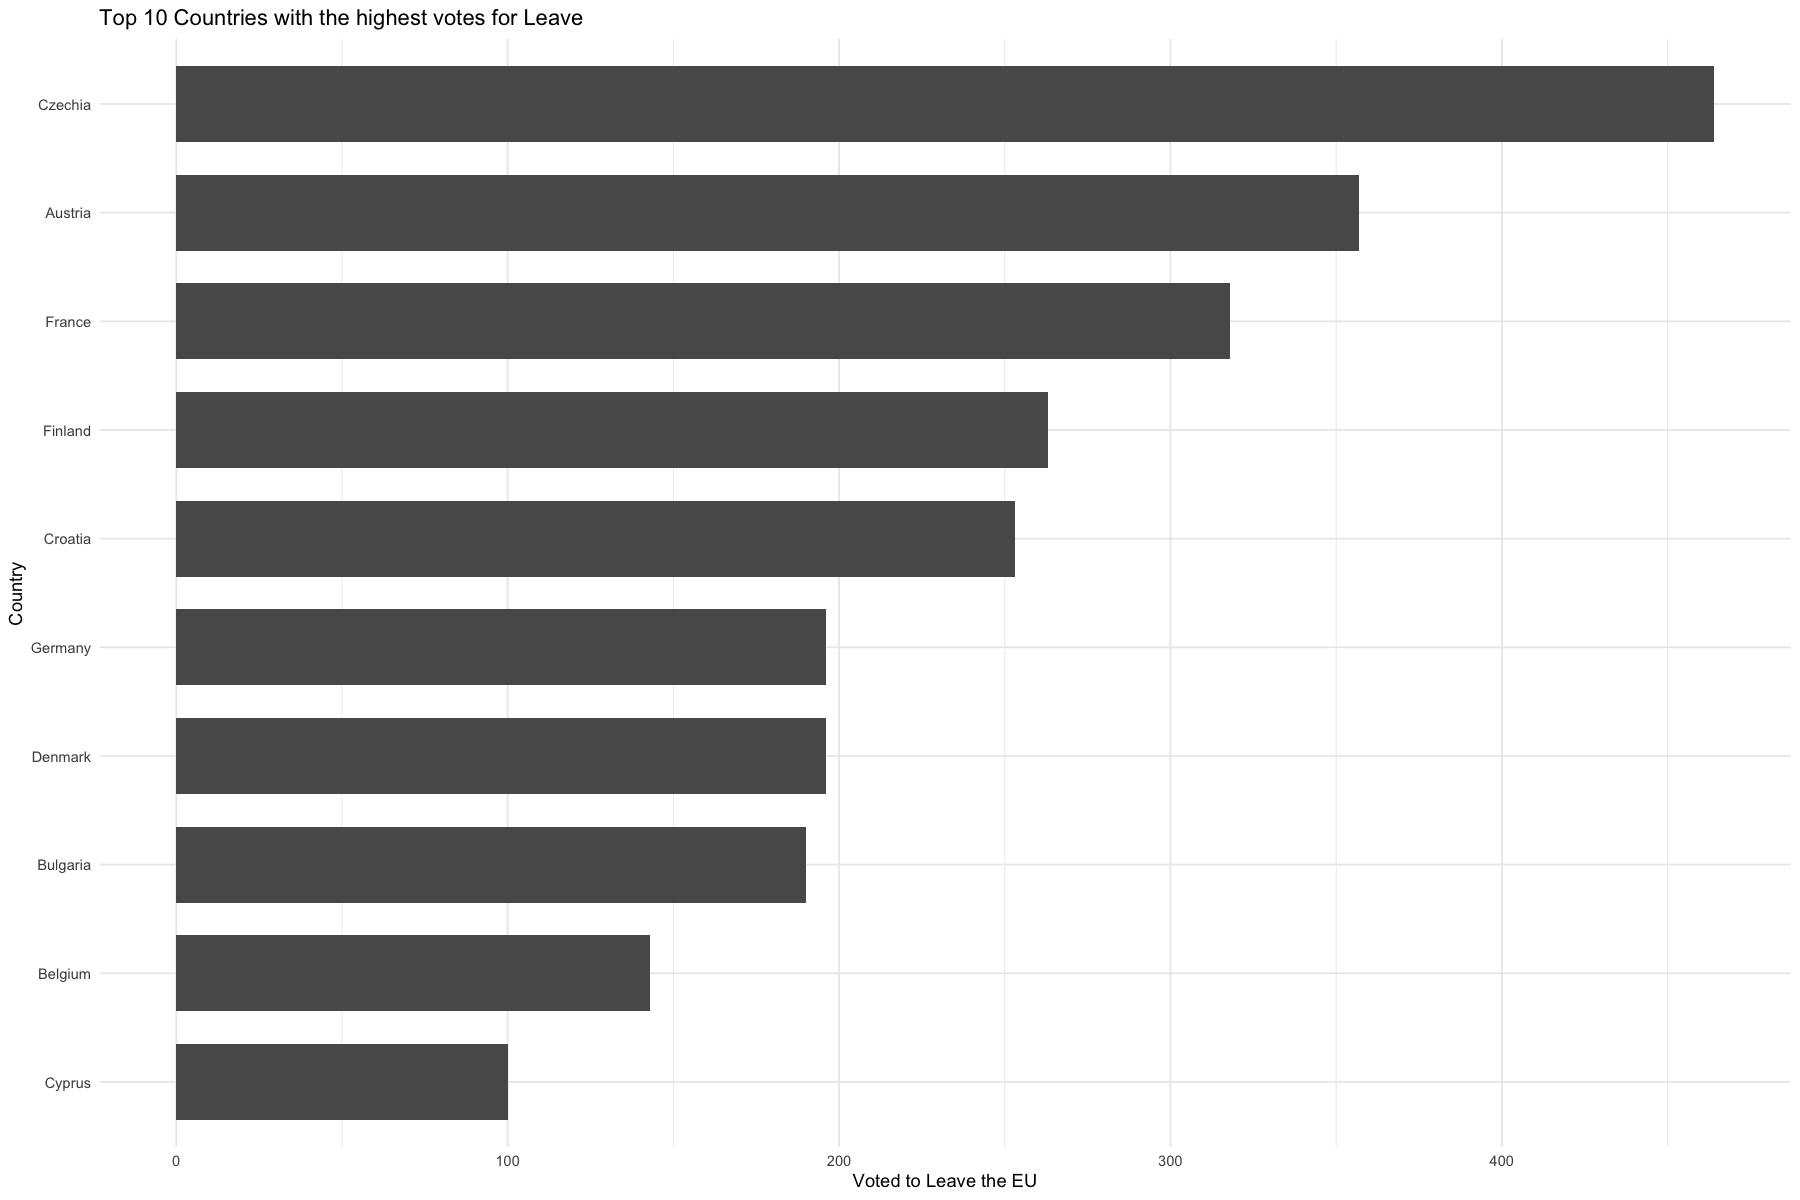

In [24]:
df_european_survey %>% group_by(Country) %>% filter(vteurmmb == "Leave") %>% summarise(n= n()) %>% head(10) %>%
  ggplot(aes(x=reorder(Country, n), y=n)) + 
  geom_bar(position="dodge",stat="identity", width = .7) +
  scale_fill_brewer(palette='Set2') +
  labs(x = "Country",
       y = "Voted to Leave the EU",
       fill = "Vote",
       title = "Top 10 Countries with the highest votes for Leave") +
         theme_minimal() + coord_flip()

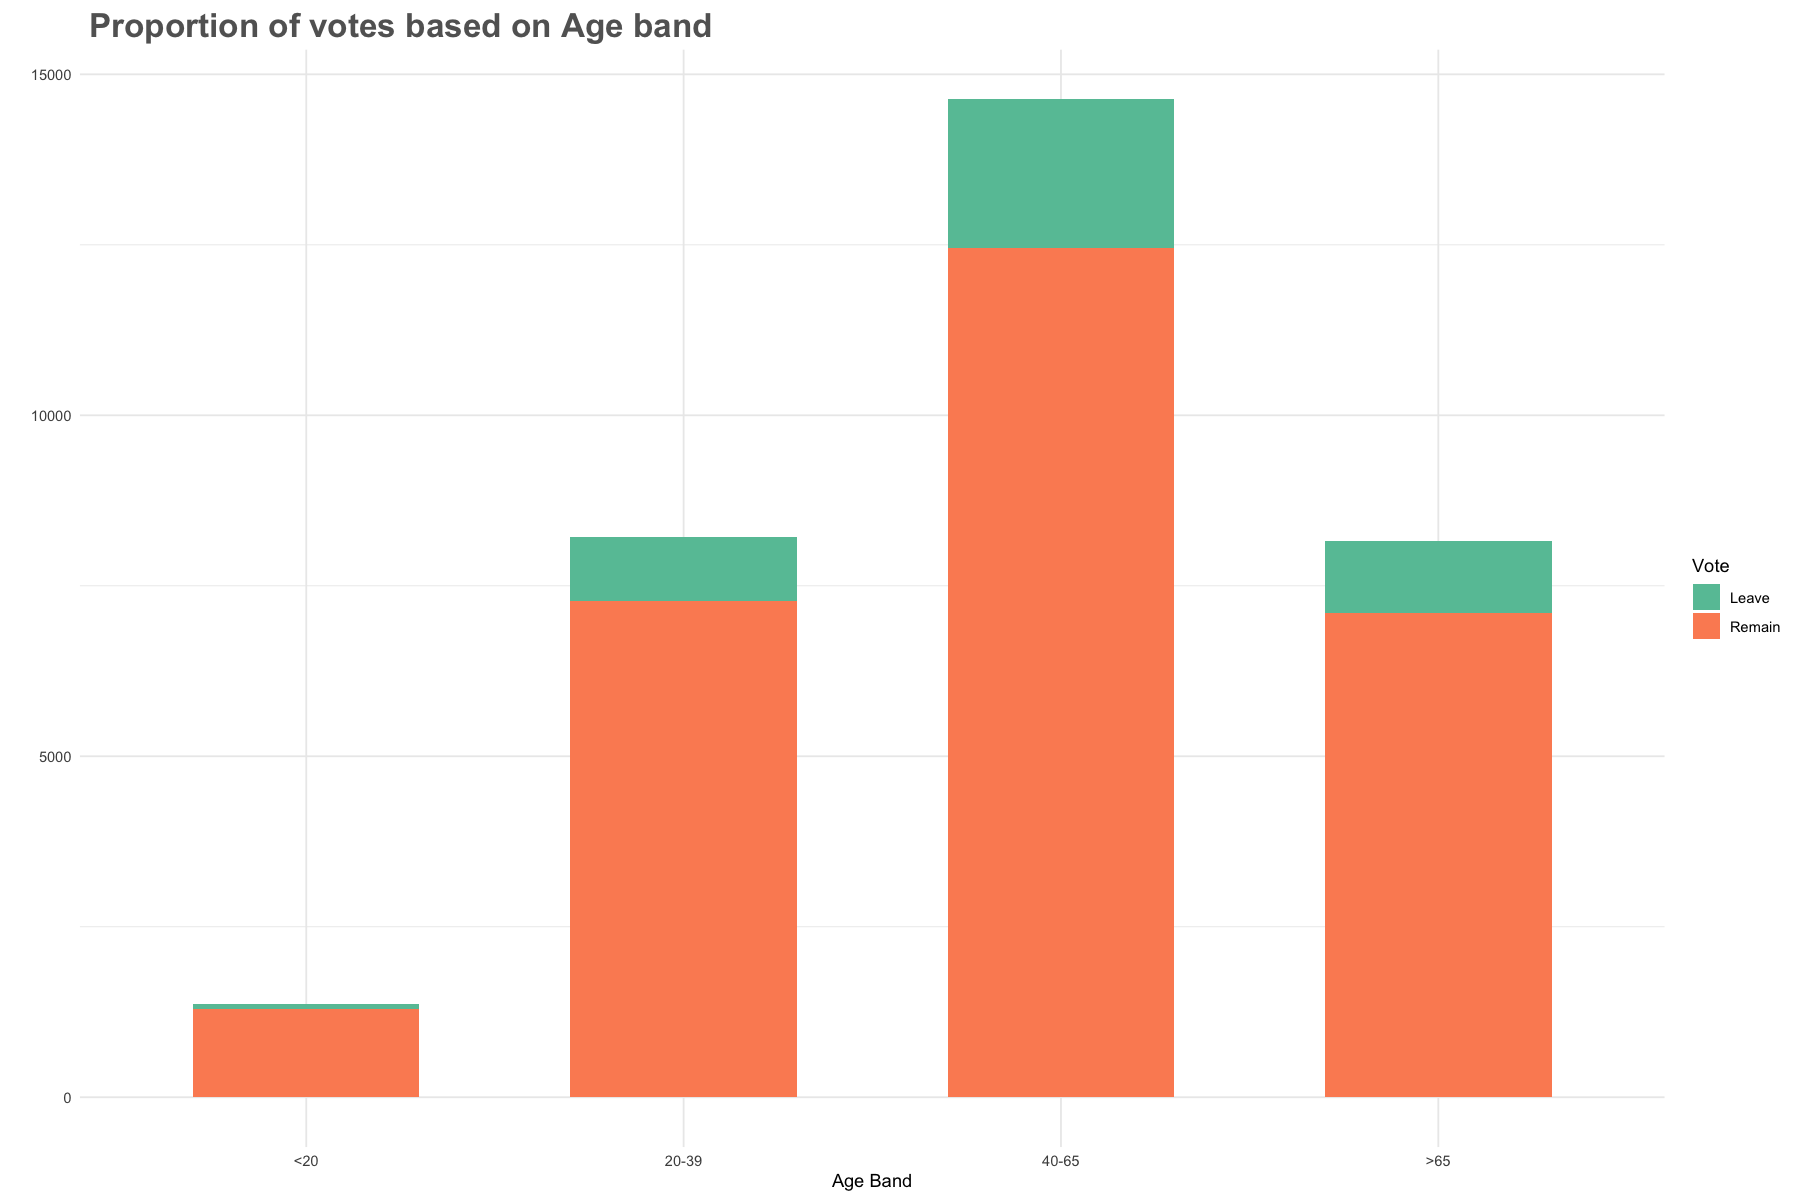

In [31]:
df_european_survey %>%
  mutate(Age_Band = factor(Age_Band, levels=c("<20", "20-39", "40-65", ">65"))) %>%
  ggplot(aes(x=Age_Band)) + 
  geom_bar(aes(fill=vteurmmb), stat="count", width = .6) +
  scale_fill_brewer(palette='Set2') +
  labs( x = "Age Band",
        y = "",
        fill = "Vote",
        title = " Proportion of votes based on Age band") + theme_minimal() +
  theme(plot.title=element_text(vjust=.5,family='', face='bold', colour='#636363', size=20))

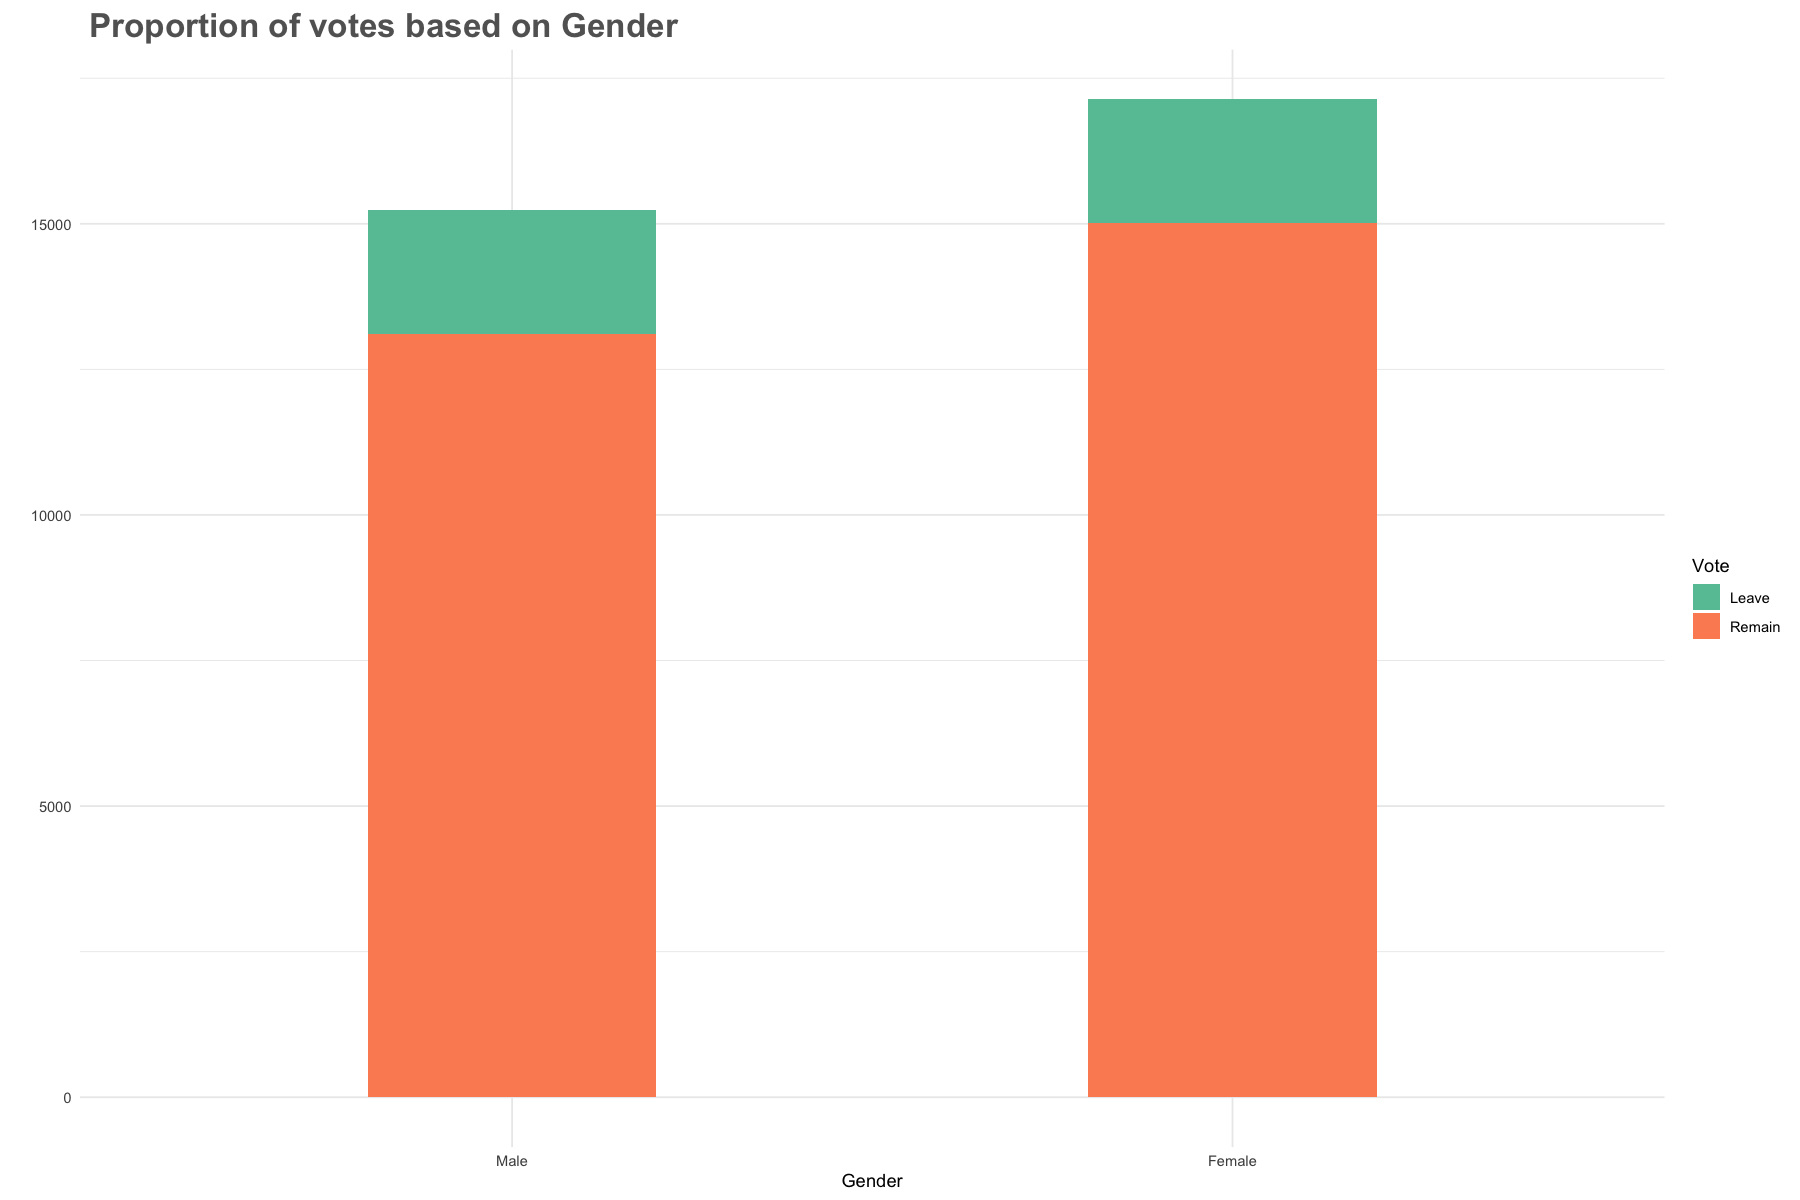

In [26]:
df_european_survey %>%
  ggplot(aes(x=gndr)) + 
  geom_bar(aes(fill=vteurmmb), stat="count", width = .4) +
  scale_fill_brewer(palette='Set2') +
  labs( x = "Gender",
        y = "",
        fill = "Vote",
        title = " Proportion of votes based on Gender") + theme_minimal() +
  theme(plot.title=element_text(vjust=.5,family='', face='bold', colour='#636363', size=20))

<a id="5"></a> <br>
<font size="+3" color="black"><b>5 - Previous Iterations</b></font><br><a id="5"></a>
<br> 

__Alternative for Proportion of votes__: Tried to a stacked bar graph but because Age <20 there is not much data it does not present well so I've switched Age and Vote

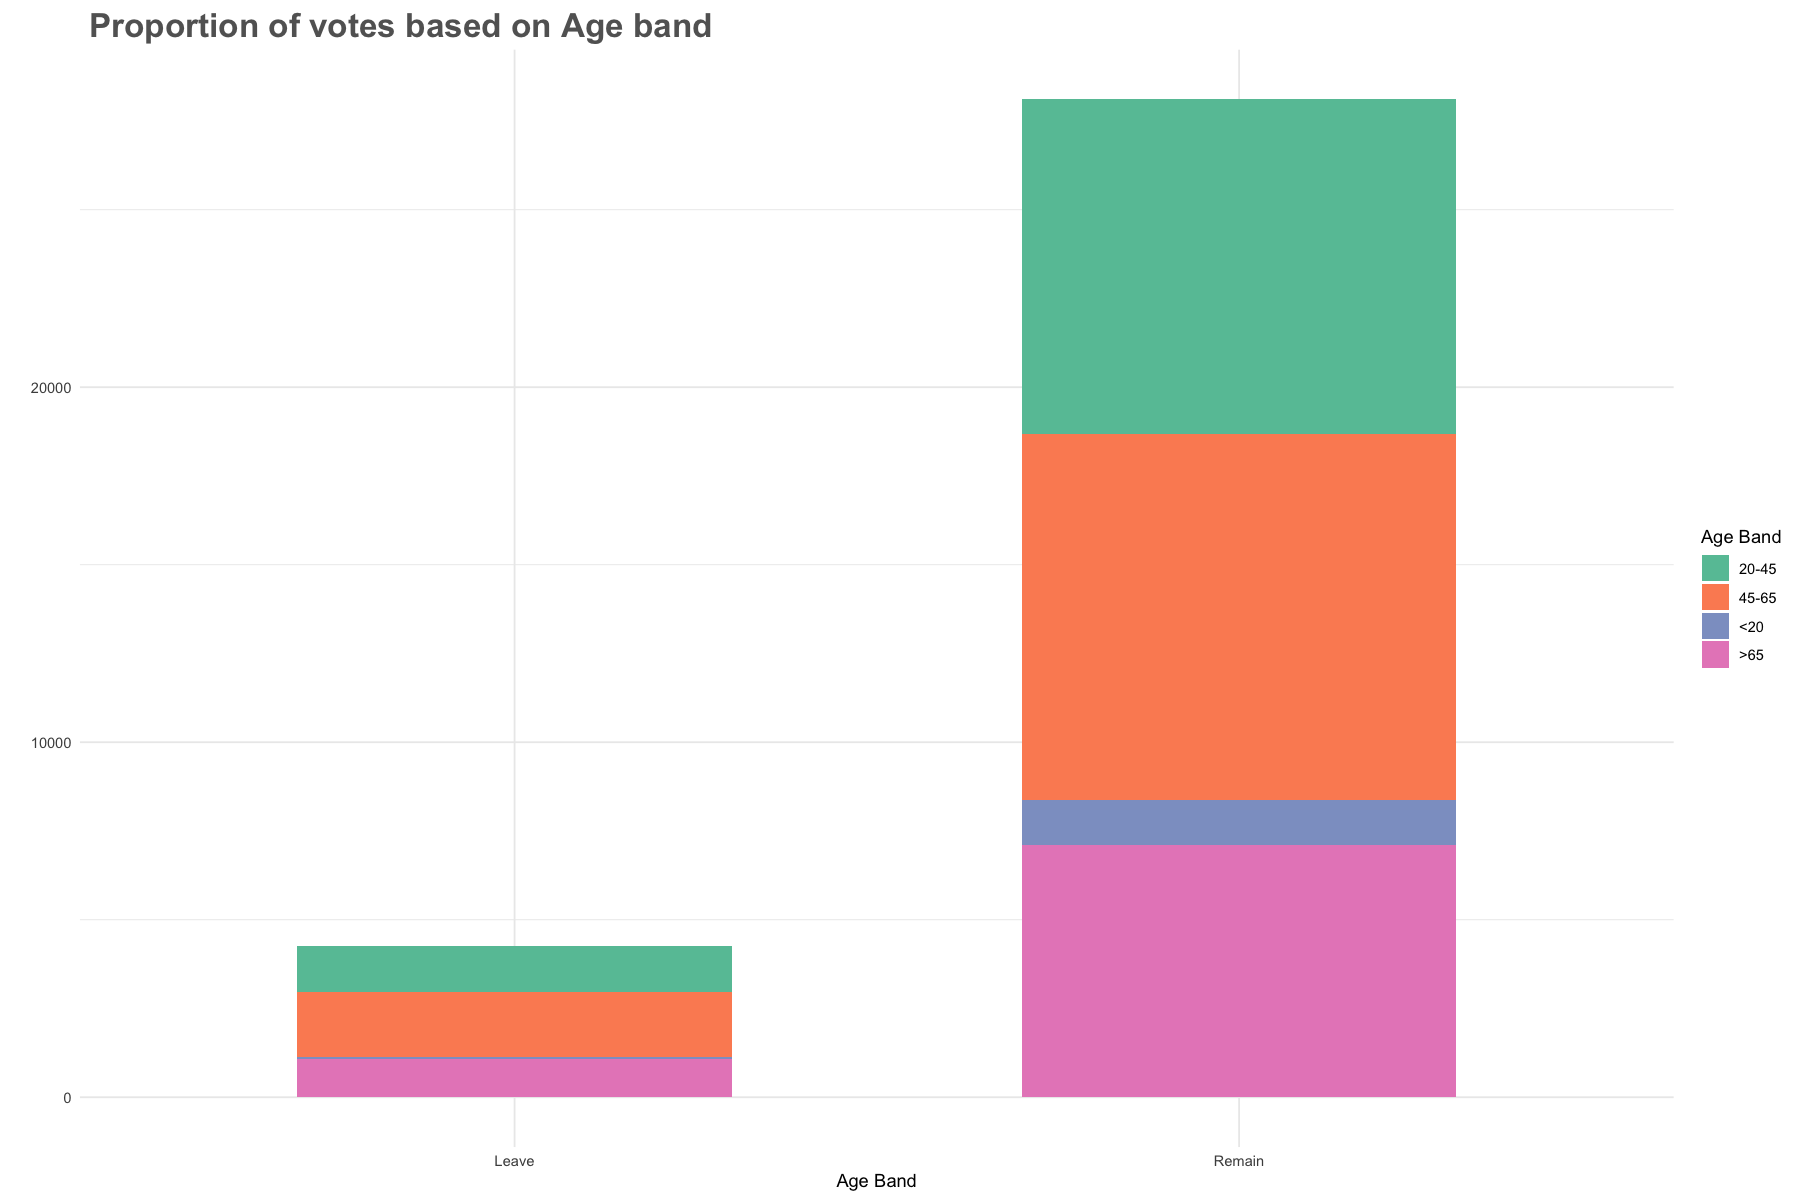

In [27]:
df_european_survey %>%
  ggplot(aes(x=vteurmmb)) + 
  geom_bar(aes(fill=Age_Band), stat="count", width = .6) +
  scale_fill_brewer(palette='Set2') +
  labs( x = "Age Band",
        y = "",
        fill = "Age Band",
        title = " Proportion of votes based on Age band") + theme_minimal() +
  theme(plot.title=element_text(vjust=.5,family='', face='bold', colour='#636363', size=20))